In [1]:
from simulation_loop import SimulationParams, simulate_many, Buffer, simulate_system

from scipy.stats import norm, uniform, gamma, expon
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
np.random.seed(42)

In [2]:
class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)
    
discharge_dist = lambda: ArrivalDistribution().rvs(size=200)
arrival_dist = ArrivalDistribution(p=0.55, offset=1)

def service_time_dist():
    return 5/60 + expon(scale=1/60).rvs()

def transport_time_dist(distance_meters):
    if distance_meters == 0:
        return 0
    speed = 1.4
    return (distance_meters / speed + expon(scale=1).rvs()) / 3600

distances = np.array([[10, 175], [175, 10]])
arrival_weights = np.array([1.0])
discharge_weights = np.array([1.0])

# Sentivity Analysis 

Service level: Percentile ≤ 10 beds

Clean buffer (daily max):
  50th percentile →  4.00 → ✅ OK
  90th percentile →  6.00 → ✅ OK
  95th percentile →  6.00 → ✅ OK
  99th percentile →  7.51 → ✅ OK

Dirty buffer (daily max):
  50th percentile → 103.00 → ❌ Exceeds
  90th percentile → 106.10 → ❌ Exceeds
  95th percentile → 107.00 → ❌ Exceeds
  99th percentile → 108.00 → ❌ Exceeds

Bed demand (daily max):
  50th percentile → 91.00 → ❌ Exceeds
  90th percentile → 95.10 → ❌ Exceeds
  95th percentile → 96.55 → ❌ Exceeds
  99th percentile → 99.00 → ❌ Exceeds


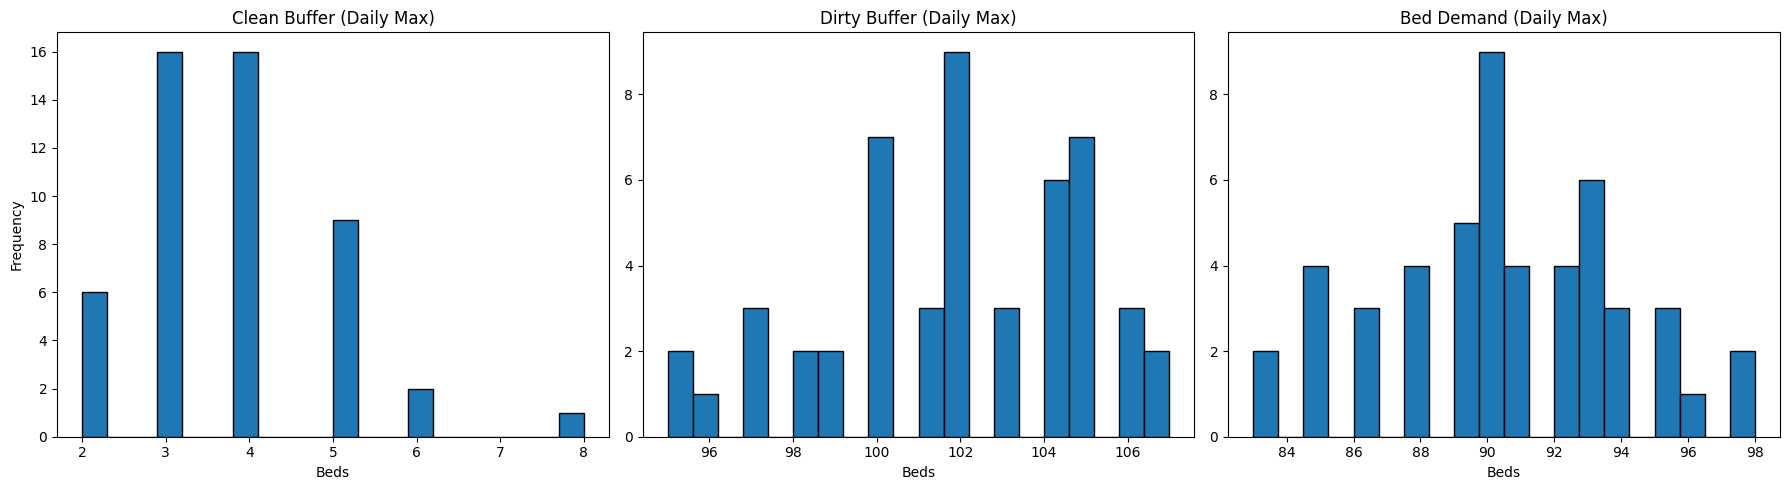

In [3]:
params = SimulationParams(
    discharge_dist=discharge_dist,
    service_time_dist=service_time_dist,
    transport_time_dist=transport_time_dist,
    distance_matrix=distances,
    arrival_weights=arrival_weights,
    discharge_weights=discharge_weights,
    n_elevators=1,
    n_robots=10
)

buffers, demands, arrivals, discharges, df = simulate_many(params, n_iters=50)
threshold = 10

# Define metrics and percentiles to check
metrics = ['Clean buffer (daily max)', 'Dirty buffer (daily max)', 'Bed demand (daily max)']
percentiles = ['50th', '90th', '95th', '99th']

# Print the results
print(f"Service level: Percentile ≤ {threshold} beds")
for metric in metrics:
    print(f"\n{metric}:")
    for p in percentiles:
        value = df.loc[metric, p]
        status = "✅ OK" if value <= threshold else "❌ Exceeds"
        print(f"  {p:>4} percentile → {value:5.2f} → {status}")

# Extract max values per run
clean_buffer_max = buffers[:, Buffer.CLEAN].max(axis=(1, 2))
dirty_buffer_max = buffers[:, Buffer.DIRTY].max(axis=(1, 2))
bed_demand_max = demands.max(axis=(1, 2))

# Plot histograms (no threshold line)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].hist(clean_buffer_max, bins=20, edgecolor='black')
axs[0].set_title('Clean Buffer (Daily Max)')
axs[0].set_xlabel('Beds')
axs[0].set_ylabel('Frequency')

axs[1].hist(dirty_buffer_max, bins=20, edgecolor='black')
axs[1].set_title('Dirty Buffer (Daily Max)')
axs[1].set_xlabel('Beds')

axs[2].hist(bed_demand_max, bins=20, edgecolor='black')
axs[2].set_title('Bed Demand (Daily Max)')
axs[2].set_xlabel('Beds')

plt.tight_layout()
plt.show()


Service level: Percentile ≤ 30 minutes

Clean Buffer Wait Time (min):
   50th percentile →   0.0 min → ✅ OK
   90th percentile →   0.0 min → ✅ OK
   95th percentile →   0.0 min → ✅ OK
   99th percentile →   1.4 min → ✅ OK

Dirty Buffer Wait Time (min):
   50th percentile →   0.0 min → ✅ OK
   90th percentile →   0.1 min → ✅ OK
   95th percentile →   0.4 min → ✅ OK
   99th percentile →   1.0 min → ✅ OK

Bed Demand Wait Time (min):
   50th percentile →   0.0 min → ✅ OK
   90th percentile →  47.2 min → ❌ Exceeds
   95th percentile →  58.6 min → ❌ Exceeds
   99th percentile →  73.7 min → ❌ Exceeds



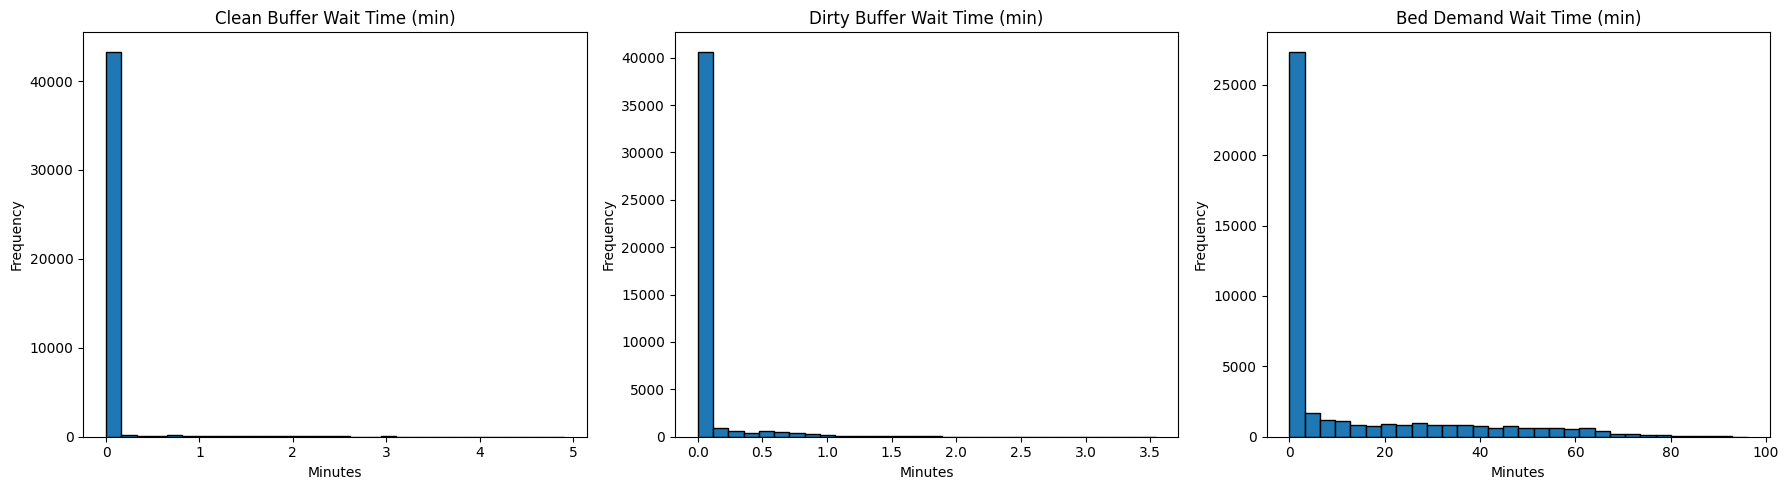

In [9]:
params = SimulationParams(
    discharge_dist=discharge_dist,
    service_time_dist=service_time_dist,
    transport_time_dist=transport_time_dist,
    distance_matrix=distances,
    arrival_weights=arrival_weights,
    discharge_weights=discharge_weights,
    n_elevators=1,
    n_robots=10
)

clean_waits = []
dirty_waits = []
demand_waits = []

# Run 10 simulations
for _ in range(10):
    _, data = simulate_system(params)

    times = data["times"]
    dt = np.diff(times, prepend=times[0]) * 60  # in minutes

    clean_q = data["buffers"][Buffer.CLEAN, 1]
    dirty_q = data["buffers"][Buffer.DIRTY, 1]
    demand_q = data["demands"][1]

    repeats = np.maximum(np.ceil(dt).astype(int), 1)  # ensure no zeros
    scaling = dt / repeats  # time slice per repeated unit

    clean_waits.append(np.repeat(clean_q, repeats) * np.repeat(scaling, repeats))
    dirty_waits.append(np.repeat(dirty_q, repeats) * np.repeat(scaling, repeats))
    demand_waits.append(np.repeat(demand_q, repeats) * np.repeat(scaling, repeats))

# Combine wait times from all runs
queue_data = {
    "Clean Buffer Wait Time (min)": np.concatenate(clean_waits),
    "Dirty Buffer Wait Time (min)": np.concatenate(dirty_waits),
    "Bed Demand Wait Time (min)": np.concatenate(demand_waits),
}

# Analyze wait times
percentiles = [50, 90, 95, 99]
threshold = 30  # minutes

print(f"Service level: Percentile ≤ {threshold} minutes\n")
for label, samples in queue_data.items():
    print(f"{label}:")
    for p in percentiles:
        val = np.percentile(samples, p)
        status = "✅ OK" if val <= threshold else "❌ Exceeds"
        print(f"  {p:>3}th percentile → {val:5.1f} min → {status}")
    print()

# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, (title, samples) in enumerate(queue_data.items()):
    axs[i].hist(samples, bins=30, edgecolor='black')
    axs[i].set_title(title)
    axs[i].set_xlabel('Minutes')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
